# Chapter 12: Least Squares Applications

## Concepts

In [42]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [32]:
# Gather Bike Rental Data

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
data = pd.read_csv(url,sep=',',encoding='unicode_escape')

In [33]:
# Converting string columns to numbers
data["Seasons"].replace(["Spring", "Summer", "Autumn", "Winter"],[1,1,0,0], inplace=True)
data["Holiday"].replace(["Holiday", "No Holiday"],[1,0], inplace=True)
data["Functioning Day"].replace(["Yes", "No"],[1,0], inplace=True)

In [34]:
# EDA
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,1
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,1
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,1
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,1
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,1


In [22]:
# EDA
data.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,0.504110
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,0.500012
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,1.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,1.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,1.000000


In [41]:
# Fit Bike Rental Data to Linear Regression model using Least Squares in numpy

# Extract features from dataset
features = data[["Rainfall(mm)",  "Seasons"]].to_numpy()

# Add new feature for intercept to create design matrix
design_matrix = np.append(features, np.ones(shape=(features.shape[0],1)), axis=1)

# Get Target variable
target_variable = data[["Rented Bike Count"]].to_numpy()

# Fit Least Squares using Numpy
results = np.linalg.lstsq(design_matrix, target_variable, rcond=None)

betas = results[0]
print(
    {
        "Betas": {
            "Rainfall(mm)":  betas[0][0],
            "Seasons":  betas[1][0],
            "Intercept":  betas[2][0]
        }
    }
)

{'Betas': {'Rainfall(mm)': -80.52367456202435, 'Seasons': 369.1266811234558, 'Intercept': 530.4945961502135}}


In [44]:
# Fit Bike Rental Data to Linear Regression model using Least Squares in statsmodels

# Create design matrix and target variable
design_matrix = data[["Rainfall(mm)",  "Seasons"]]
target_variable = data[["Rented Bike Count"]]

# Fit data using statsmodels OLS
design_matrix = sm.add_constant(design_matrix)
model = sm.OLS(target_variable, design_matrix).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Rented Bike Count   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     468.8
Date:                Sat, 25 May 2024   Prob (F-statistic):          3.80e-194
Time:                        10:50:56   Log-Likelihood:                -68654.
No. Observations:                8760   AIC:                         1.373e+05
Df Residuals:                    8757   BIC:                         1.373e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          530.4946      9.313     56.963   

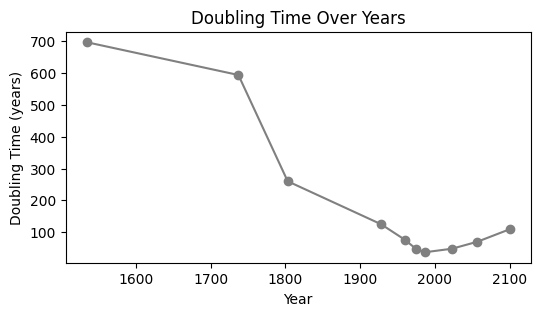

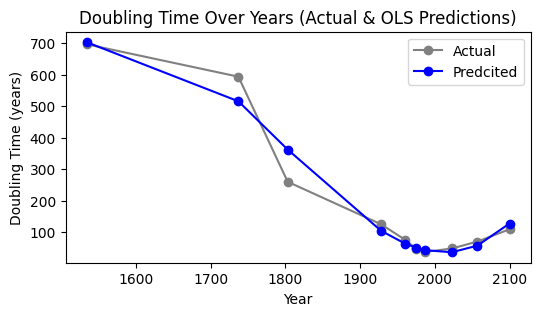

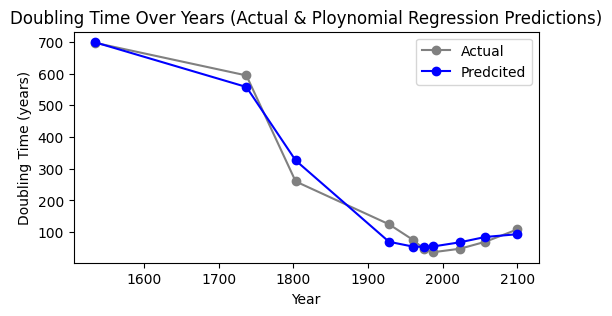

In [65]:
# Fit world population data using polynomial regression via numpy

# define data
year = [1534, 1737, 1803, 1928, 1960, 1975, 1987, 2023, 2057, 2100]
double_time = [697, 594, 260, 125, 76, 47, 37, 48, 70, 109]

# Plot data
plt.figure(figsize=(6, 3))
plt.plot(year, double_time, marker='o', linestyle='-', color='grey')
plt.title('Doubling Time Over Years')
plt.xlabel('Year')
plt.ylabel('Doubling Time (years)')
plt.show()

# Perform Linear regression using numpy lstsq
design_matrix = np.zeros(shape=(10, 4))
for i in range(4):
    design_matrix[:, i] = np.array(year)**i

results = np.linalg.lstsq(design_matrix, double_time, rcond=None)
betas = results[0]

predictions = design_matrix @ betas

# Plot numpy lstsq results
plt.figure(figsize=(6, 3))
plt.plot(year, double_time, marker='o', linestyle='-', color='grey')
plt.plot(year, predictions, marker='o', linestyle='-', color='blue')
plt.title('Doubling Time Over Years (Actual & OLS Predictions)')
plt.xlabel('Year')
plt.ylabel('Doubling Time (years)')
plt.legend(['Actual', 'Predcited'])
plt.show()

# Perform linear regression via numpy polyfit
betas = np.polyfit(year, double_time, deg=4)
predictions = np.polyval(betas, year)

# Plot numpy polyfit results
plt.figure(figsize=(6, 3))
plt.plot(year, double_time, marker='o', linestyle='-', color='grey')
plt.plot(year, predictions, marker='o', linestyle='-', color='blue')
plt.title('Doubling Time Over Years (Actual & Ploynomial Regression Predictions)')
plt.xlabel('Year')
plt.ylabel('Doubling Time (years)')
plt.legend(['Actual', 'Predcited'])
plt.show()

## Code Exercises

In [ ]:
# Exercise 12-1 (Re-fit bike data after eliminating no rainfall instances)

In [ ]:
# Exercise 12-2 (Re-fit bike data after replacing seasons with temperature data)

In [ ]:
# Exercise 12-3 (Re-fit bike data after creating new feature that is a linear combination of temperature and rainfall)

In [ ]:
# Exercise 12-4 (Experiment with regularization effects on outcomes)

In [ ]:
# Exercise 12-5 (Polynomial regression with varying orders)

In [ ]:
# Exercise 12-6 (Perform Grid Search to find parameters for Linear Regression)

In [ ]:
# Exercise 12-7 (Evaluating Linear Regression using R^2)